# Finetune: weights from pre-training with 20% of pre-training data

In this notebook, we perform full finetuning on the PhysioNet dataset using a  ResNet18 with weights from 20% of pre-training data. This will be compared with the baseline result of randomly initialized ResNet18.

## Computational Requirements

We run this notebook in Google Colab Pro to utilize GPU resources. We perform finetuning using the **V100 GPU**.

## Data

We have prepared the PhysioNet data in a separate notebook ([Github](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/finetuning_explore.ipynb)). That notebook generates _train_ and _test_ datasets.

In our case, the datasets are saved to our Google Drive at these paths:

1. `/content/drive/MyDrive/Project/data/physionet_finetune/physionet_train.pkl`
2. `/content/drive/MyDrive/Project/data/physionet_finetune/physionet_test.pkl`

On this data, the preprocessing is as follows:
1. Downsample the PhysioNet data to 250 hz
2. Pad recordings to ~65 second length
3. Normalize the recordings.


## Preparation

### Mount Google Drive

In [1]:
# You may also manually mount drive by clicking on folder icon in left sidebar
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Clone code repo

Assuming this notebook is run on Colab Pro, please clone our repo to the instance.

Sample commands to run in Colab Pro Terminal:

```bash
$ cd /root
# enter your username and github PAT
$ git clone https://github.com/myles-i/DLH_TransferLearning.git
$ cd DLH_TransferLearning
```

We will assume the code to run is on `master` branch.

### Install dependencies

We will install the dependencies from the `requirements.txt` file in the cloned repo.

In [2]:
REPO = '/root/DLH_TransferLearning/'
%cd $REPO

/root/DLH_TransferLearning


In [3]:
%%capture
! pip install -r requirements.txt

## Finetuning

Below we set up the paths to the:
1. `DATA_DIR`: location where the input files are
2. `JOB_DIR`: location where to save the output of the finetuning (model weights, history, etc.)

In [4]:
PROJECT_ROOT = '/content/drive/MyDrive/CS598_DLH/Project'
DATA_DIR = PROJECT_ROOT + '/data'
JOB_DIR = PROJECT_ROOT + '/jobs'
#! mkdir -p $JOB_DIR

Next, we set up the actual input and output paths relative to the `DATA_DIR` and `JOB_DIR`, respectively.

In [5]:
train = DATA_DIR + '/physionet_finetune/physionet_train.pkl'
test = DATA_DIR + '/physionet_finetune/physionet_test.pkl'
job_name = 'finetune_pretrain_20_weights_65sec'
job_dir = JOB_DIR + '/' + job_name

print(f"train: {train}")
print(f"test: {test}")
print(f"job_dir: {job_dir}")

train: /content/drive/MyDrive/CS598_DLH/Project/data/physionet_finetune/physionet_train.pkl
test: /content/drive/MyDrive/CS598_DLH/Project/data/physionet_finetune/physionet_test.pkl
job_dir: /content/drive/MyDrive/CS598_DLH/Project/jobs/finetune_pretrain_20_weights_65sec


In [ ]:
"""job_dir = JOB_DIR + '/finetune_random_cnn_original_data_with_f1'
train = DATA_DIR + '/physionet_finetune/physionet_train.pkl'
test = DATA_DIR + '/physionet_finetune/physionet_test.pkl'

print(f"job_dir: {job_dir}")
print(f"train: {train}")
print(f"test: {test}")"""

job_dir: /content/drive/MyDrive/DLHProject/jobs/finetune_random_cnn_original_data_with_f1
train: /content/drive/MyDrive/DLHProject/data/physionet_finetune/physionet_train.pkl
test: /content/drive/MyDrive/DLHProject/data/physionet_finetune/physionet_test.pkl


Since we have pretrained our ResNet18, let's extract its weights from a model checkpoint. We will then load the weights to ResNet18 at the beginning of fine tuning stage.

In [8]:
! cd $CHECKPOINT_FILE
! ls

/bin/bash: line 1: cd: ../content/drive/MyDrive/CS598_DLH/Project/Mylesgitrepo/jobs/beat_classification_16epochs_to_20percent/epoch_16: No such file or directory
environment.yml  git-ops.ipynb	    pretraining  report			  transplant
example.ipynb	 jupyter_notebooks  proposal	 requirements-daniel.txt
finetuning	 LICENSE	    README.md	 requirements.txt


In [11]:
from pretraining.utils import get_pretrained_weights


CHECKPOINT_FILE = '../../content/drive/MyDrive/CS598_DLH/Project/Mylesgitrepo/jobs/beat_classification_16epochs_to_20percent/epoch_16'
WEIGHTS_FILE = JOB_DIR + '/beat_classification/pre_trained_20_resnet18.weights'

resnet18 = get_pretrained_weights(
    checkpoint_file=CHECKPOINT_FILE + '/model.weights',
    task='beat',
    arch='resnet18')
resnet18.save_weights(WEIGHTS_FILE)

The paper authors provide us this script that will perform the finetuning. We will run it below and expand on the meaning of the parameter values.
- `--weights-file $WEIGHTS_FILE`: Path to pretrained weights or a checkpoint of the model to be used for model initialization.

- `--val-size 0.0625`: This is the percentage of the train set size to set aside for the validation set.

  Note that the PhysioNet data was already split 80-20 train-test. The paper uses 5 percent of the full dataset for validation. We get this via $0.0625 * 0.8 = 0.05$
- `--val-metric "f1"`: Use macro F1 score to evaluate performance on validation set and to find the best model at each epoch.
- `--arch "resnet18"` means we are using ResNet18 CNN.
- `--batch-size 128` we found this value through trial and error that maximizes the utilization of the V100 GPU's 16 GB RAM.
- `--epochs 200` This is taken from the paper.
- `--seed 2024` this is the random seed used in splitting the train set into validation. This is for reproducibility.
- `--verbose` this prints out the finetuning progress epoch by epoch.


In [12]:
%%time
!python -m finetuning.trainer \
--job-dir $job_dir \
--train $train \
--test $test \
--weights-file $WEIGHTS_FILE \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 200 \
--seed 2024 \
--verbose

2024-04-12 16:40:44.373580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 16:40:44.373642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 16:40:44.374959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 16:40:45.391202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /content/drive/MyDrive/CS598_DLH/Project/jobs/finetune_pretrain_20_weights_65sec
Setting random state 2024
Loading train data from /content/drive/MyDrive/CS598_DLH/Project/data/physionet_finetune/physionet_train

It took 24m 12s to run 64 epochs, as the paper authors have set up early stopping to end training if the loss on validation set does not decrease for more than 50 epochs.



In [15]:
! cd $job_dir
! ls

environment.yml  git-ops.ipynb	    pretraining  report			  transplant
example.ipynb	 jupyter_notebooks  proposal	 requirements-daniel.txt
finetuning	 LICENSE	    README.md	 requirements.txt


In [18]:
import pandas as pd

history = pd.read_csv(job_dir + '/history.csv')
history.head()

,epoch,acc,f1,loss,val_acc,val_loss
0,0,0.707115,0.725081,0.736346,0.826698,0.536657
1,1,0.800626,0.760417,0.496790,0.838408,0.445110
2,2,0.826896,0.777882,0.450944,0.852459,0.432654
3,3,0.838155,0.771402,0.411350,0.850117,0.444485
4,4,0.857545,0.777765,0.382270,0.854801,0.405071


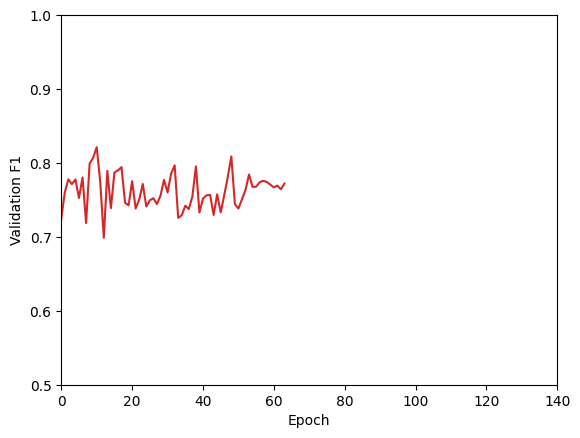

In [19]:
from matplotlib import pyplot as plt

_ = plt.plot(history['epoch'], history['f1'], color='tab:red')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Validation F1')
ax = plt.gca()
_ = ax.set_xlim([0, 140])
_ = ax.set_ylim([0.5, 1.0])